In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from sklearn.preprocessing import MinMaxScaler
import matplotlib.cbook as cbook
import tensorflow as tf
#import kerastuner as kt
from tensorflow.keras.losses import MeanAbsoluteError
import keras
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
path = r'/content/gdrive/MyDrive/transformed' # use your path
bus_all_files = glob.glob(path + "/bus/*.csv")
car_all_files = glob.glob(path + "/car/*.csv")
pedestrian_all_files = glob.glob(path + "/pedestrian/*.csv")
static_all_files = glob.glob(path + "/static/*.csv")
train_all_files = glob.glob(path + "/train/*.csv")  

In [ ]:
all_files_train=[]
all_files_test=[]

In [ ]:
bus_all_files.sort()
all_files_train = all_files_train + bus_all_files[:-5]
all_files_test = all_files_test + bus_all_files[-5:]

car_all_files.sort()
all_files_train = all_files_train + car_all_files[:-5]
all_files_test = all_files_test + car_all_files[-5:]

pedestrian_all_files.sort()
all_files_train = all_files_train + pedestrian_all_files[:-5]
all_files_test = all_files_test + pedestrian_all_files[-5:]

static_all_files.sort()
all_files_train = all_files_train + static_all_files[:-5]
all_files_test = all_files_test + static_all_files[-5:]

train_all_files.sort()
all_files_train = all_files_train + train_all_files[:-5]
all_files_test = all_files_test + train_all_files[-5:]

In [ ]:
# Train Dataset
li_train = []
for filename in all_files_train:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_train.append(df)
frame_train = pd.concat(li_train, axis=0, ignore_index=True)
frame_train.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
0,7,7,10,7,7,0,0,310,3,3,...,7.0,7.0,10.0,10.0,0,0,14,7,7,1769
1,7,7,7,10,7,0,0,0,310,3,...,8.0,7.0,7.0,10.0,0,0,0,14,7,2272
2,7,7,7,7,10,0,0,0,0,310,...,8.0,8.0,7.0,7.0,0,0,0,0,14,2549
3,9,7,7,7,7,1757,0,0,0,0,...,10.0,8.0,8.0,7.0,68,0,0,0,0,2674
4,9,9,7,7,7,4216,1757,0,0,0,...,10.0,10.0,8.0,8.0,151,68,0,0,0,2393


In [ ]:
# Test Dataset
li_test = []
for filename in all_files_test:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_test.append(df)
frame_test = pd.concat(li_test, axis=0, ignore_index=True)
frame_test.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
0,8,8,8,8,8,3657,5413,7795,7795,6777,...,6.0,6.0,6.0,7.0,162,100,143,143,128,4656
1,8,8,8,8,8,4719,3657,5413,7795,7795,...,4.0,6.0,6.0,6.0,155,162,100,143,143,5294
2,6,8,8,8,8,7280,4719,3657,5413,7795,...,4.0,4.0,6.0,6.0,144,155,162,100,143,6627
3,7,6,8,8,8,3813,7280,4719,3657,5413,...,3.0,4.0,4.0,6.0,70,144,155,162,100,9069
4,7,7,6,8,8,4742,3813,7280,4719,3657,...,3.0,3.0,4.0,4.0,86,70,144,155,162,10859


# Dealing with Nan Values

In [ ]:
frame_train.replace('-', np.NaN, inplace = True)
frame_train.isna().sum().sum()

frame_test.replace('-', np.NaN, inplace = True)
frame_test.isna().sum().sum()

167064

In [ ]:
imputer = IterativeImputer(imputation_order='ascending',max_iter=10,random_state=42,n_nearest_features=None)
imputed_dataset = imputer.fit_transform(frame_train)
frame_train = pd.DataFrame(imputed_dataset,columns = frame_train.columns)
frame_train.isna().sum().sum()



imputer = IterativeImputer(imputation_order='ascending',max_iter=10,random_state=42,n_nearest_features=None)
imputed_dataset = imputer.fit_transform(frame_test)
frame_test = pd.DataFrame(imputed_dataset,columns = frame_test.columns)
frame_test.isna().sum().sum()

0

In [ ]:
# LOW - below 1000
# MEDIUM - between 1000 and 4000
# HIGH - greater than 4000

In [ ]:
def categorise(row):  
    if row['DL_bitrate'] <= 1000:
        return 0
    elif row['DL_bitrate'] > 1000 and row['DL_bitrate'] <= 4000:
        return 1
    elif row['DL_bitrate'] > 4000:
        return 2
    return

In [ ]:
frame_train['Class'] = frame_train.apply(lambda row: categorise(row), axis=1)
frame_test['Class'] = frame_test.apply(lambda row: categorise(row), axis=1)

In [ ]:
frame_train['Class'].value_counts()

2    80397
1    37144
0    31850
Name: Class, dtype: int64

In [ ]:
frame_test['Class'].value_counts()

2    19528
1     3369
0     1020
Name: Class, dtype: int64

In [ ]:
col_names_scaled =['CQI-0', 'CQI-1', 'CQI-2', 'CQI-3', 'CQI-4', 'DL_bitrate-0',
       'DL_bitrate-1', 'DL_bitrate-2', 'DL_bitrate-3', 'DL_bitrate-4', 'SNR-0', 'SNR-1', 'SNR-2', 'SNR-3', 'SNR-4','DL_bitrate']

### With Scaling

#### MinMax Scaler

In [ ]:
df = frame_train[col_names_scaled]

In [ ]:
df = frame_train[col_names_scaled]
min_max_scaler = MinMaxScaler()
# transform data
X = pd.DataFrame(min_max_scaler.fit_transform(df))
X = X.iloc[: , :-1]

In [ ]:
Y=frame_train['Class']

In [ ]:
'''from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
base_learners = [5, 10, 50, 100, 200,  500, 1000]
depth = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14]
#gamma = [0, 0.1,0.2,0.4,0.8,1.6,3.2,6.4,25.6,102.4]
learning_rate = [0.01, 0.03, 0.06, 0.1]
weights = [1, 10, 25, 50, 99]
param_grid = {'n_estimators': base_learners,'max_depth': depth,  'learning_rate': learning_rate, 'scale_pos_weight': weights}
XGB = XGBClassifier()
model = GridSearchCV(XGB, param_grid, scoring = 'accuracy', cv=5 , n_jobs = -1,pre_dispatch=2)
model.fit(X, Y)
print("Model with best parameters :\n",model.best_estimator_)'''

'from xgboost.sklearn import XGBClassifier\nfrom sklearn.model_selection import GridSearchCV\nbase_learners = [5, 10, 50, 100, 200,  500, 1000]\ndepth = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14]\n#gamma = [0, 0.1,0.2,0.4,0.8,1.6,3.2,6.4,25.6,102.4]\nlearning_rate = [0.01, 0.03, 0.06, 0.1]\nweights = [1, 10, 25, 50, 99]\nparam_grid = {\'n_estimators\': base_learners,\'max_depth\': depth,  \'learning_rate\': learning_rate, \'scale_pos_weight\': weights}\nXGB = XGBClassifier()\nmodel = GridSearchCV(XGB, param_grid, scoring = \'accuracy\', cv=5 , n_jobs = -1,pre_dispatch=2)\nmodel.fit(X, Y)\nprint("Model with best parameters :\n",model.best_estimator_)'

In [ ]:
from xgboost.sklearn import XGBClassifier
model = XGBClassifier(max_depth=5, n_estimators=10,learning_rate=0.01, objective='multi:softmax',class_weight='balanced')
model.fit(X, Y)

XGBClassifier(class_weight='balanced', learning_rate=0.01, max_depth=5,
              n_estimators=10, objective='multi:softprob')

In [ ]:
df_test = frame_test[col_names_scaled]
scaler = MinMaxScaler()
# transform data
X_test = pd.DataFrame(scaler.fit_transform(df_test))
X_test = X_test.iloc[: , :-1]
y_test = frame_test['Class']

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred) 

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 89.55%


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [ ]:
cm_df = pd.DataFrame(cm,
                     index = ['Low','Medium','High'], 
                     columns = ['Low','Medium','High'])

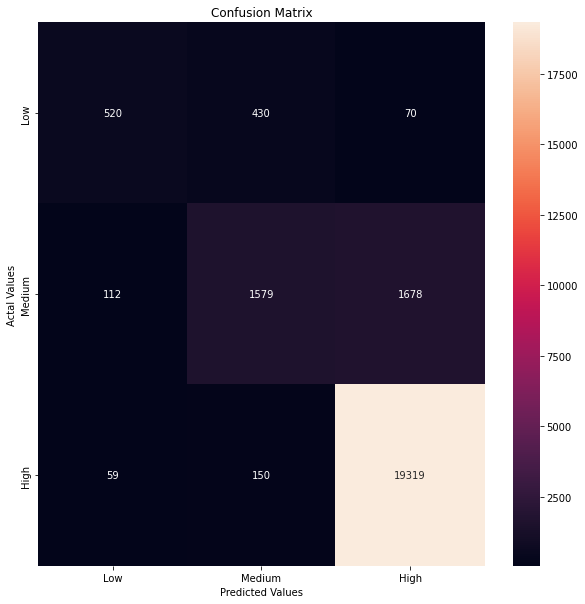

In [ ]:
#Plotting the confusion matrix
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True,fmt='.6g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
#LOGISTIC REGRESSION

from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(multi_class='multinomial', C= 1000, penalty= 'l2', max_iter=100)
logreg.fit(X,Y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(C=1000, multi_class='multinomial')

In [ ]:
df_test = frame_test[col_names_scaled]
scaler = MinMaxScaler()
# transform data
X_test = pd.DataFrame(scaler.fit_transform(df_test))
X_test = X_test.iloc[: , :-1]
y_test = frame_test['Class']

In [ ]:
y_pred = logreg.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred) 

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.17%


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [ ]:
cm_df = pd.DataFrame(cm,
                     index = ['Low','Medium','High'], 
                     columns = ['Low','Medium','High'])

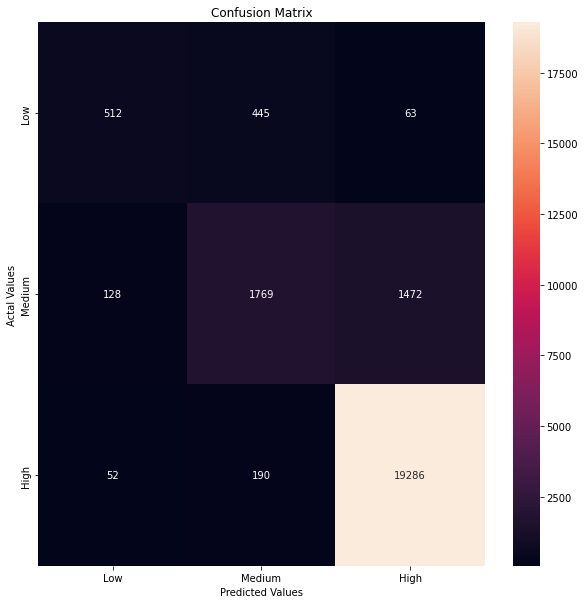

In [ ]:
#Plotting the confusion matrix
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True,fmt='.6g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

# Model splitting

In [ ]:
frame_low_train = frame_train[frame_train['DL_bitrate']<=1000]
frame_medium_train = frame_train[(frame_train['DL_bitrate']>1000) & (frame_train['DL_bitrate']<=4000)]
frame_high_train = frame_train[frame_train['DL_bitrate']>4000]

In [ ]:
frame_low_test = frame_test[frame_test['DL_bitrate']<=1000]
frame_medium_test = frame_test[(frame_test['DL_bitrate']>1000) & (frame_test['DL_bitrate']<=4000)]
frame_high_test = frame_test[frame_test['DL_bitrate']>4000]

# low Throughput Model

In [ ]:
print(frame_low_train.shape)
print(frame_low_test.shape)

(31850, 47)
(1020, 47)


In [ ]:
df = frame_low_train[col_names_scaled]
min_max_scaler = MinMaxScaler()
# transform data
df_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))

In [ ]:
X_train_min_max_scaler, X_valid_min_max_scaler, Y_train_min_max_scaler, Y_valid_min_max_scaler = train_test_split(df_min_max_scaled.iloc[:,:-1], df_min_max_scaled.iloc[:,-1:], test_size=0.3, random_state=0)
print('Train set shape', X_train_min_max_scaler.shape)
print('Validation set shape', X_valid_min_max_scaler.shape)
X_train_min_max_scaler.head()

Train set shape (22295, 15)
Validation set shape (9555, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
204,0.476762,0.422289,0.427024,0.424320,0.437894,0.004111,0.011549,0.008078,0.004295,0.003895,0.616808,0.595800,0.583324,0.585223,0.585488
2884,0.478894,0.421484,0.429174,0.424516,0.435203,0.005387,0.010392,0.006218,0.007287,0.007329,0.617959,0.595583,0.584821,0.582448,0.583093
12002,0.162398,0.071429,0.071429,0.071429,0.091956,0.000000,0.000000,0.000000,0.000000,0.000000,0.396825,0.412698,0.492063,0.492063,0.567232
10415,0.420122,0.357143,0.357143,0.357143,0.441204,0.014262,0.014090,0.021940,0.011256,0.013108,0.492063,0.492063,0.460317,0.460317,0.441181
30766,0.479513,0.421411,0.426475,0.427393,0.438688,0.007599,0.008078,0.009917,0.010931,0.008111,0.619360,0.592991,0.583595,0.585887,0.580323


In [ ]:
X_train_min_max_series = X_train_min_max_scaler.values.reshape((X_train_min_max_scaler.shape[0], X_train_min_max_scaler.shape[1], 1))
X_valid_min_max_series = X_valid_min_max_scaler.values.reshape((X_valid_min_max_scaler.shape[0], X_valid_min_max_scaler.shape[1], 1))
print('Train set shape', X_train_min_max_series.shape)
print('Validation set shape', X_valid_min_max_series.shape)

Train set shape (22295, 15, 1)
Validation set shape (9555, 15, 1)


In [ ]:
mae = MeanAbsoluteError()
model_low = keras.Sequential()
model_low.add(keras.layers.Flatten(input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))
model_low.add(Dense(units=480, activation='relu'))
model_low.add(Dropout(rate=0))
model_low.add(tf.keras.layers.Dense(units=224, activation='relu'))
model_low.add(Dropout(rate=0))
model_low.add(tf.keras.layers.Dense(units=128, activation='relu'))
model_low.add(Dropout(rate=0))
model_low.add(Dense(1, kernel_initializer='normal', activation='linear'))
model_low.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=mae,metrics=[mae])
model_low.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 15)                0         
                                                                 
 dense (Dense)               (None, 480)               7680      
                                                                 
 dropout (Dropout)           (None, 480)               0         
                                                                 
 dense_1 (Dense)             (None, 224)               107744    
                                                                 
 dropout_1 (Dropout)         (None, 224)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               28800     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0

In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, 
        verbose=1, mode='auto', restore_best_weights=True)
history=model_low.fit(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler),
        callbacks=[monitor],verbose=1,epochs=500)

Epoch 1/500
697/697 [==============================] - 5s 3ms/step - loss: 0.2083 - mean_absolute_error: 0.2083 - val_loss: 0.1338 - val_mean_absolute_error: 0.1337
Epoch 2/500
697/697 [==============================] - 2s 3ms/step - loss: 0.1154 - mean_absolute_error: 0.1154 - val_loss: 0.1041 - val_mean_absolute_error: 0.1042
Epoch 3/500
697/697 [==============================] - 2s 3ms/step - loss: 0.1040 - mean_absolute_error: 0.1040 - val_loss: 0.1103 - val_mean_absolute_error: 0.1104
Epoch 4/500
697/697 [==============================] - 2s 3ms/step - loss: 0.1009 - mean_absolute_error: 0.1008 - val_loss: 0.0979 - val_mean_absolute_error: 0.0980
Epoch 5/500
697/697 [==============================] - 2s 3ms/step - loss: 0.0995 - mean_absolute_error: 0.0995 - val_loss: 0.0964 - val_mean_absolute_error: 0.0965
Epoch 6/500
697/697 [==============================] - 2s 3ms/step - loss: 0.0975 - mean_absolute_error: 0.0975 - val_loss: 0.0954 - val_mean_absolute_error: 0.0954
Epoch 7/50

In [ ]:
kt_train_pred_min_max_scaled = model_low.predict(X_train_min_max_scaler)
kt_valid_pred_min_max_scaled = model_low.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, kt_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, kt_valid_pred_min_max_scaled)))

Train rmse: 0.16811504270759134
Validation rmse: 0.16815555449089478


In [ ]:
df = frame_low_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.214286,0.357143,0.428571,0.428571,0.357143,0.008830,0.020145,0.023466,0.027873,0.033135,0.2500,0.2500,0.193548,0.225806,0.193548
1,0.214286,0.214286,0.357143,0.428571,0.428571,0.009910,0.008584,0.020145,0.024735,0.033135,0.1875,0.2500,0.225806,0.193548,0.225806
2,0.285714,0.214286,0.214286,0.357143,0.428571,0.011167,0.009634,0.008584,0.021235,0.029405,0.1875,0.1875,0.225806,0.225806,0.193548
3,0.285714,0.285714,0.214286,0.214286,0.357143,0.019046,0.010856,0.009634,0.009049,0.025244,0.1250,0.1875,0.161290,0.225806,0.225806
4,0.285714,0.285714,0.285714,0.214286,0.214286,0.016387,0.018516,0.010856,0.010155,0.010757,0.1250,0.1250,0.161290,0.161290,0.225806


In [ ]:
Y_test = frame_low_test['DL_bitrate']
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = model_low.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

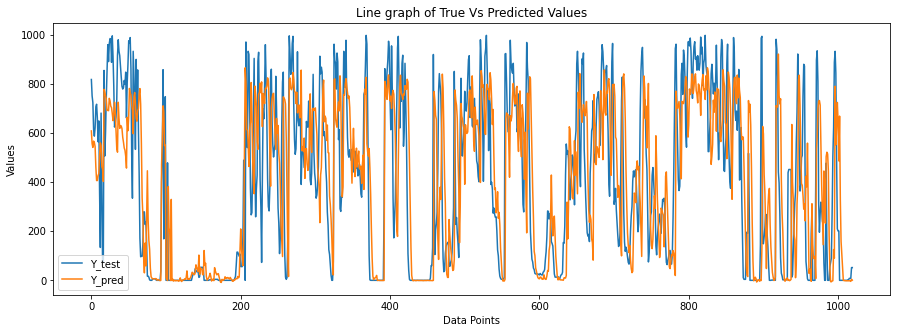

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('Line graph of True Vs Predicted Values')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

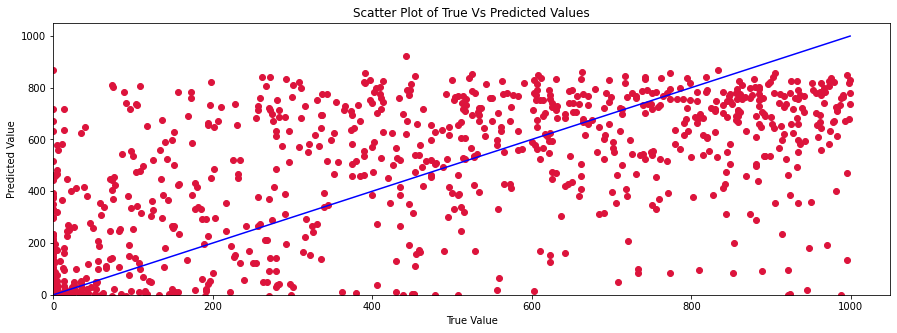

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.scatter(Y_test, Y_pred[15], c='crimson')
p1 = max(max(Y_pred[15]), max(Y_test))
p2 = min(min(Y_pred[15]), min(Y_test))
ax3.plot([p1, p2], [p1, p2], 'b-')
ax3.set(xlim=(0, None),ylim=(0, None), title='Scatter Plot of True Vs Predicted Values', xlabel='True Value', ylabel='Predicted Value')
plt.show()

# Medium Throughput Model

In [ ]:
print(frame_medium_train.shape)
print(frame_medium_test.shape)

(37144, 47)
(3369, 47)


In [ ]:
df = frame_medium_train[col_names_scaled]
min_max_scaler = MinMaxScaler()
# transform data
df_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))

In [ ]:
X_train_min_max_scaler, X_valid_min_max_scaler, Y_train_min_max_scaler, Y_valid_min_max_scaler = train_test_split(df_min_max_scaled.iloc[:,:-1], df_min_max_scaled.iloc[:,-1:], test_size=0.3, random_state=0)
print('Train set shape', X_train_min_max_scaler.shape)
print('Validation set shape', X_valid_min_max_scaler.shape)
X_train_min_max_scaler.head()

Train set shape (26000, 15)
Validation set shape (11144, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
7493,0.428571,0.357143,0.357143,0.500000,0.500000,0.053615,0.069853,0.053112,0.022695,0.028797,0.533333,0.533333,0.533333,0.525424,0.509732
7923,0.071429,0.071429,0.214286,0.285714,0.142857,0.026103,0.000463,0.017158,0.009200,0.003462,0.350000,0.416667,0.416667,0.491525,0.476846
4382,0.436085,0.425319,0.429443,0.430708,0.439829,0.108197,0.114549,0.107842,0.056044,0.069550,0.650503,0.622075,0.611434,0.629541,0.614157
35223,0.420718,0.423255,0.428570,0.425641,0.434054,0.082788,0.094798,0.112203,0.036319,0.035251,0.644899,0.626824,0.610981,0.632799,0.618718
15830,0.142857,0.357143,0.357143,0.357143,0.357143,0.009865,0.041394,0.046704,0.027119,0.021509,0.566667,0.566667,0.566667,0.576271,0.542618


In [ ]:
X_train_min_max_series = X_train_min_max_scaler.values.reshape((X_train_min_max_scaler.shape[0], X_train_min_max_scaler.shape[1], 1))
X_valid_min_max_series = X_valid_min_max_scaler.values.reshape((X_valid_min_max_scaler.shape[0], X_valid_min_max_scaler.shape[1], 1))
print('Train set shape', X_train_min_max_series.shape)
print('Validation set shape', X_valid_min_max_series.shape)

Train set shape (26000, 15, 1)
Validation set shape (11144, 15, 1)


In [ ]:
mae = MeanAbsoluteError()
model_medium = keras.Sequential()
model_medium.add(keras.layers.Flatten(input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))
model_medium.add(Dense(units=320, activation='relu'))
model_medium.add(Dropout(rate=0))
model_medium.add(tf.keras.layers.Dense(units=256, activation='relu'))
model_medium.add(Dropout(rate=0))
model_medium.add(tf.keras.layers.Dense(units=64, activation='relu'))
model_medium.add(Dropout(rate=0))
model_medium.add(Dense(1, kernel_initializer='normal', activation='linear'))
model_medium.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=mae,metrics=[mae])
model_medium.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 15)                0         
                                                                 
 dense_4 (Dense)             (None, 320)               5120      
                                                                 
 dropout_3 (Dropout)         (None, 320)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               82176     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 dropout_5 (Dropout)         (None, 64)               

In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, 
        verbose=1, mode='auto', restore_best_weights=True)
history=model_medium.fit(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler),
        callbacks=[monitor],verbose=1,epochs=500)

Epoch 1/500
813/813 [==============================] - 3s 3ms/step - loss: 0.2200 - mean_absolute_error: 0.2200 - val_loss: 0.1985 - val_mean_absolute_error: 0.1984
Epoch 2/500
813/813 [==============================] - 2s 3ms/step - loss: 0.1898 - mean_absolute_error: 0.1898 - val_loss: 0.1851 - val_mean_absolute_error: 0.1851
Epoch 3/500
813/813 [==============================] - 2s 3ms/step - loss: 0.1859 - mean_absolute_error: 0.1859 - val_loss: 0.1849 - val_mean_absolute_error: 0.1848
Epoch 4/500
813/813 [==============================] - 2s 3ms/step - loss: 0.1851 - mean_absolute_error: 0.1851 - val_loss: 0.1840 - val_mean_absolute_error: 0.1839
Epoch 5/500
813/813 [==============================] - 2s 3ms/step - loss: 0.1847 - mean_absolute_error: 0.1848 - val_loss: 0.1838 - val_mean_absolute_error: 0.1838
Epoch 6/500
813/813 [==============================] - 2s 3ms/step - loss: 0.1841 - mean_absolute_error: 0.1840 - val_loss: 0.1885 - val_mean_absolute_error: 0.1885
Epoch 7/50

In [ ]:
kt_train_pred_min_max_scaled = model_medium.predict(X_train_min_max_scaler)
kt_valid_pred_min_max_scaled = model_medium.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, kt_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, kt_valid_pred_min_max_scaled)))

Train rmse: 0.22906532553850972
Validation rmse: 0.23167759889703324


In [ ]:
df = frame_medium_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.571429,0.571429,0.571429,0.571429,0.571429,0.149834,0.266937,0.275872,0.268310,0.163936,0.486486,0.542857,0.542857,0.514286,0.552632
1,0.642857,0.571429,0.571429,0.571429,0.571429,0.171239,0.175926,0.215241,0.087259,0.101241,0.594595,0.600000,0.600000,0.600000,0.631579
2,0.500000,0.642857,0.571429,0.571429,0.571429,0.115223,0.171299,0.175926,0.213944,0.080333,0.594595,0.628571,0.600000,0.600000,0.631579
3,0.500000,0.500000,0.642857,0.571429,0.571429,0.150185,0.115263,0.171299,0.174866,0.196963,0.567568,0.628571,0.628571,0.600000,0.631579
4,0.500000,0.500000,0.500000,0.642857,0.571429,0.080260,0.150238,0.115263,0.170267,0.160987,0.567568,0.600000,0.628571,0.628571,0.631579


In [ ]:
Y_test = frame_medium_test['DL_bitrate']
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = model_medium.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

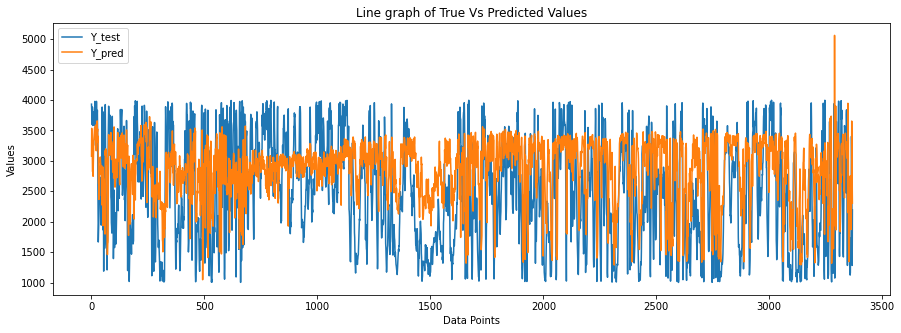

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('Line graph of True Vs Predicted Values')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

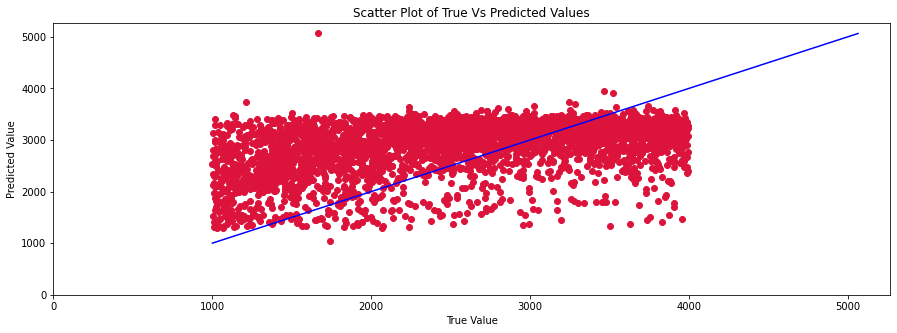

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.scatter(Y_test, Y_pred[15], c='crimson')
p1 = max(max(Y_pred[15]), max(Y_test))
p2 = min(min(Y_pred[15]), min(Y_test))
ax3.plot([p1, p2], [p1, p2], 'b-')
ax3.set(xlim=(0, None),ylim=(0, None), title='Scatter Plot of True Vs Predicted Values', xlabel='True Value', ylabel='Predicted Value')
plt.show()

# High Throughput Model

In [ ]:
print(frame_high_train.shape)
print(frame_high_test.shape)

(80397, 47)
(19528, 47)


In [ ]:
df = frame_high_train[col_names_scaled]
min_max_scaler = MinMaxScaler()
# transform data
df_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))

In [ ]:
X_train_min_max_scaler, X_valid_min_max_scaler, Y_train_min_max_scaler, Y_valid_min_max_scaler = train_test_split(df_min_max_scaled.iloc[:,:-1], df_min_max_scaled.iloc[:,-1:], test_size=0.3, random_state=0)
print('Train set shape', X_train_min_max_scaler.shape)
print('Validation set shape', X_valid_min_max_scaler.shape)
X_train_min_max_scaler.head()

Train set shape (56277, 15)
Validation set shape (24120, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
50917,0.428571,0.428571,0.428571,0.428571,0.500000,0.030315,0.040719,0.058821,0.057012,0.090171,0.404942,0.319149,0.319149,0.319149,0.319149
64249,0.571429,0.642857,0.642857,0.642857,0.642857,0.065740,0.099546,0.085131,0.079571,0.086743,0.665280,0.595745,0.595745,0.574468,0.574468
62411,0.928571,0.928571,1.000000,1.000000,0.928571,0.071687,0.079894,0.077952,0.075629,0.078796,0.795449,0.765957,0.787234,0.787234,0.787234
11919,0.429317,0.426476,0.431791,0.431395,0.435991,0.030639,0.029668,0.026304,0.026050,0.035095,0.569806,0.479780,0.464455,0.467499,0.472891
78496,0.421994,0.424152,0.435989,0.441410,0.432397,0.009820,0.017969,0.031801,0.036586,0.024755,0.572538,0.475262,0.468027,0.470563,0.454919


In [ ]:
X_train_min_max_series = X_train_min_max_scaler.values.reshape((X_train_min_max_scaler.shape[0], X_train_min_max_scaler.shape[1], 1))
X_valid_min_max_series = X_valid_min_max_scaler.values.reshape((X_valid_min_max_scaler.shape[0], X_valid_min_max_scaler.shape[1], 1))
print('Train set shape', X_train_min_max_series.shape)
print('Validation set shape', X_valid_min_max_series.shape)

Train set shape (56277, 15, 1)
Validation set shape (24120, 15, 1)


In [ ]:
mae = MeanAbsoluteError()
model_high = keras.Sequential()
model_high.add(keras.layers.Flatten(input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))
model_high.add(Dense(units=352, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(tf.keras.layers.Dense(units=352, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(tf.keras.layers.Dense(units=160, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(Dense(1, kernel_initializer='normal', activation='linear'))
model_high.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=mae,metrics=[mae])
model_high.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 15)                0         
                                                                 
 dense_8 (Dense)             (None, 352)               5632      
                                                                 
 dropout_6 (Dropout)         (None, 352)               0         
                                                                 
 dense_9 (Dense)             (None, 352)               124256    
                                                                 
 dropout_7 (Dropout)         (None, 352)               0         
                                                                 
 dense_10 (Dense)            (None, 160)               56480     
                                                                 
 dropout_8 (Dropout)         (None, 160)              

In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, 
        verbose=1, mode='auto', restore_best_weights=True)
history=model_high.fit(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler),
        callbacks=[monitor],verbose=1,epochs=500)

Epoch 1/500
1759/1759 [==============================] - 5s 3ms/step - loss: 0.0244 - mean_absolute_error: 0.0244 - val_loss: 0.0226 - val_mean_absolute_error: 0.0226
Epoch 2/500
1759/1759 [==============================] - 5s 3ms/step - loss: 0.0229 - mean_absolute_error: 0.0229 - val_loss: 0.0232 - val_mean_absolute_error: 0.0232
Epoch 3/500
1759/1759 [==============================] - 5s 3ms/step - loss: 0.0229 - mean_absolute_error: 0.0229 - val_loss: 0.0223 - val_mean_absolute_error: 0.0223
Epoch 4/500
1759/1759 [==============================] - 5s 3ms/step - loss: 0.0227 - mean_absolute_error: 0.0227 - val_loss: 0.0229 - val_mean_absolute_error: 0.0229
Epoch 5/500
1759/1759 [==============================] - 5s 3ms/step - loss: 0.0226 - mean_absolute_error: 0.0226 - val_loss: 0.0229 - val_mean_absolute_error: 0.0229
Epoch 6/500
1759/1759 [==============================] - 5s 3ms/step - loss: 0.0225 - mean_absolute_error: 0.0225 - val_loss: 0.0230 - val_mean_absolute_error: 0.023

In [ ]:
kt_train_pred_min_max_scaled = model_high.predict(X_train_min_max_scaler)
kt_valid_pred_min_max_scaled = model_high.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, kt_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, kt_valid_pred_min_max_scaled)))

Train rmse: 0.03601832560901857
Validation rmse: 0.03599554721919756


In [ ]:
df = frame_high_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.500000,0.500000,0.500000,0.5,0.5,0.033645,0.049801,0.071716,0.071716,0.062350,0.454545,0.500000,0.500000,0.500000,0.522727
1,0.500000,0.500000,0.500000,0.5,0.5,0.043416,0.033645,0.049801,0.071716,0.071716,0.454545,0.454545,0.500000,0.500000,0.500000
2,0.357143,0.500000,0.500000,0.5,0.5,0.066978,0.043416,0.033645,0.049801,0.071716,0.431818,0.454545,0.454545,0.500000,0.500000
3,0.428571,0.357143,0.500000,0.5,0.5,0.035080,0.066978,0.043416,0.033645,0.049801,0.431818,0.431818,0.454545,0.454545,0.500000
4,0.428571,0.428571,0.357143,0.5,0.5,0.043627,0.035080,0.066978,0.043416,0.033645,0.409091,0.431818,0.431818,0.454545,0.454545


In [ ]:
Y_test = frame_high_test['DL_bitrate']
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = model_high.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

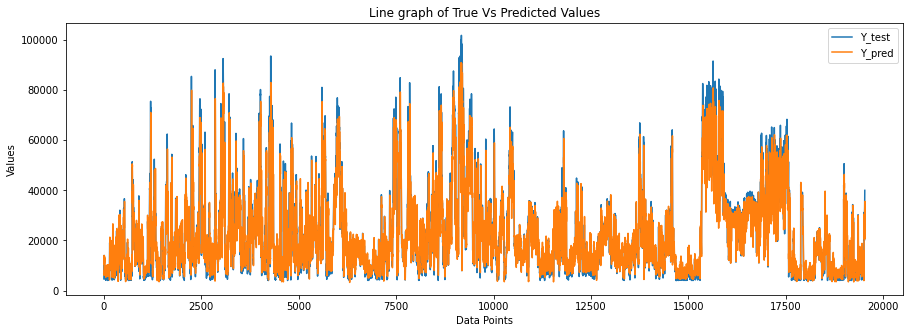

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('Line graph of True Vs Predicted Values')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

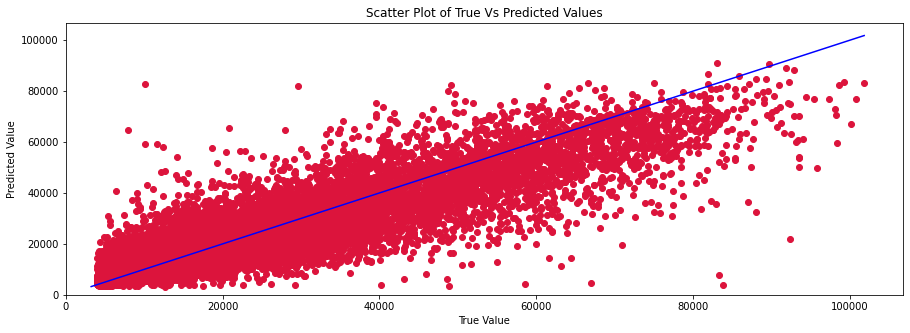

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.scatter(Y_test, Y_pred[15], c='crimson')
p1 = max(max(Y_pred[15]), max(Y_test))
p2 = min(min(Y_pred[15]), min(Y_test))
ax3.plot([p1, p2], [p1, p2], 'b-')
ax3.set(xlim=(0, None),ylim=(0, None), title='Scatter Plot of True Vs Predicted Values', xlabel='True Value', ylabel='Predicted Value')
plt.show()

In [ ]:
category = model.predict(X_test)

In [ ]:
'''from keras.models import load_model
model_low = load_model('/content/model_low.h5')
model_medium = load_model('/content/model_medium.h5')
model_high = load_model('/content/model_high.h5')'''

"from keras.models import load_model\nmodel_low = load_model('/content/model_low.h5')\nmodel_medium = load_model('/content/model_medium.h5')\nmodel_high = load_model('/content/model_high.h5')"

In [ ]:
X_test[15]=category

In [ ]:
X_test_low = X_test[(X_test[15] == 0)]
X_test_medium = X_test[(X_test[15] == 1)]
X_test_high = X_test[(X_test[15] == 2)]

In [ ]:
X_test_low.drop([15],axis=1,inplace=True)
X_test_medium.drop([15],axis=1,inplace=True)
X_test_high.drop([15],axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
X_test.drop([15],axis=1,inplace=True)

In [ ]:
l=[]
for idx, row in X_test.iterrows():
    if(category[idx]==0):
      l.append(model_low.predict(row.to_numpy().reshape(1,-1)).reshape(-1).tolist())
    if(category[idx]==1):
      l.append(model_medium.predict(row.to_numpy().reshape(1,-1)).reshape(-1).tolist())
    if(category[idx]==2):
      l.append(model_high.predict(row.to_numpy().reshape(1,-1)).reshape(-1).tolist())  
      
      

In [ ]:
l

[[0.029422743245959282],
 [0.029663532972335815],
 [0.04043292626738548],
 [0.024945860728621483],
 [0.02625221572816372],
 [0.021489014849066734],
 [0.03509421646595001],
 [0.0762212872505188],
 [0.09841159731149673],
 [0.10213030874729156],
 [0.10163886100053787],
 [0.10169465839862823],
 [0.08064749836921692],
 [0.06503917276859283],
 [0.06971690058708191],
 [0.1004515141248703],
 [0.08796136826276779],
 [0.07498391717672348],
 [0.08109574019908905],
 [0.08621394634246826],
 [0.09310092031955719],
 [0.08470098674297333],
 [0.08244751393795013],
 [0.0712583065032959],
 [0.04922797903418541],
 [0.03799484297633171],
 [0.0428449884057045],
 [0.03491036221385002],
 [0.045941080898046494],
 [0.04816931113600731],
 [0.05125390738248825],
 [0.060044433921575546],
 [0.0439678430557251],
 [0.032278139144182205],
 [0.027712153270840645],
 [0.032266765832901],
 [0.032804906368255615],
 [0.03761783987283707],
 [0.0398375540971756],
 [0.023202713578939438],
 [0.029620826244354248],
 [0.046545930

In [ ]:
from functools import reduce
import operator
out = reduce(operator.concat, l)

In [ ]:
out

[0.029422743245959282,
 0.029663532972335815,
 0.04043292626738548,
 0.024945860728621483,
 0.02625221572816372,
 0.021489014849066734,
 0.03509421646595001,
 0.0762212872505188,
 0.09841159731149673,
 0.10213030874729156,
 0.10163886100053787,
 0.10169465839862823,
 0.08064749836921692,
 0.06503917276859283,
 0.06971690058708191,
 0.1004515141248703,
 0.08796136826276779,
 0.07498391717672348,
 0.08109574019908905,
 0.08621394634246826,
 0.09310092031955719,
 0.08470098674297333,
 0.08244751393795013,
 0.0712583065032959,
 0.04922797903418541,
 0.03799484297633171,
 0.0428449884057045,
 0.03491036221385002,
 0.045941080898046494,
 0.04816931113600731,
 0.05125390738248825,
 0.060044433921575546,
 0.0439678430557251,
 0.032278139144182205,
 0.027712153270840645,
 0.032266765832901,
 0.032804906368255615,
 0.03761783987283707,
 0.0398375540971756,
 0.023202713578939438,
 0.029620826244354248,
 0.046545930206775665,
 0.05285652354359627,
 0.0531686507165432,
 0.03950069099664688,
 0.0310

In [ ]:
X_test[15]=out

In [ ]:
df_test = pd.DataFrame(min_max_scaler.inverse_transform(X_test))
Y_pred = df_test.iloc[:,-1:]

In [ ]:

Y_pred.loc[Y_pred[15] <0, 15] = 0

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [ ]:
Y_test = frame_test['DL_bitrate']
Y_test.reset_index(drop=True,inplace=True)

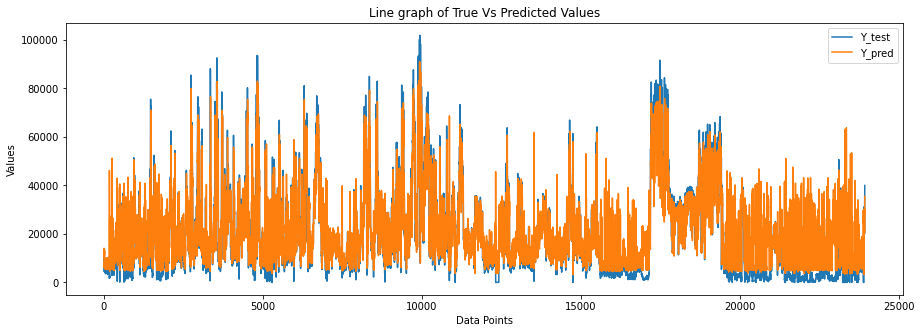

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('Line graph of True Vs Predicted Values')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

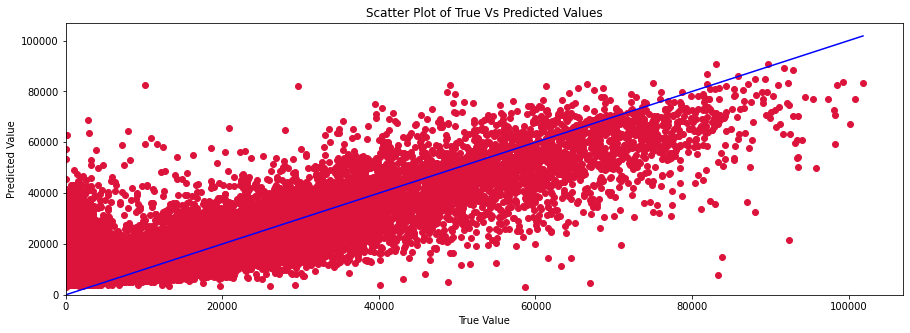

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.scatter(Y_test, Y_pred[15], c='crimson')
p1 = max(max(Y_pred[15]), max(Y_test))
p2 = min(min(Y_pred[15]), min(Y_test))
ax3.plot([p1, p2], [p1, p2], 'b-')
ax3.set(xlim=(0, None),ylim=(0, None), title='Scatter Plot of True Vs Predicted Values', xlabel='True Value', ylabel='Predicted Value')
plt.show()

In [ ]:
Y_pred_series = Y_pred[15]

In [ ]:
Y_pred_series

0         6879.574085
1         6903.131748
2         7956.755341
3         6441.578284
4         6569.385526
             ...     
23912    24714.218458
23913    27408.751640
23914    29963.859932
23915    33503.596274
23916    35493.798834
Name: 15, Length: 23917, dtype: float64

In [ ]:
Y_test

0         4656.0
1         5294.0
2         6627.0
3         9069.0
4        10859.0
          ...   
23912    35336.0
23913    36745.0
23914    38188.0
23915    39011.0
23916    39987.0
Name: DL_bitrate, Length: 23917, dtype: float64

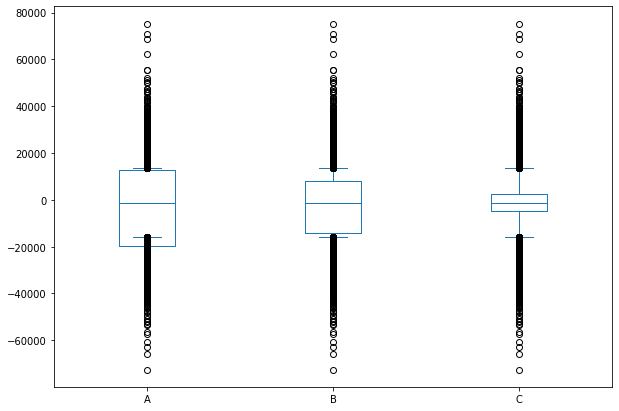

In [ ]:
a=Y_test.subtract(Y_pred_series)
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred_series)

# display
print("Mean absolute error : " + str(error))
print(f"Decimal Representation: {error:.20f}")

Mean absolute error : tf.Tensor(6609.57763671875, shape=(), dtype=float64)
Decimal Representation: 6609.57763671875000000000


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred_series)

0.6127957647793407

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred_series)

0.4415468762806322